The stakeholder ist Amy Williams. Sie is a Mafiosi Seller of several central houses(top10%) over time, she needs average outskirt houses over time to hide from the FBI. I assume she has those already and doenst need to buy those.

I derive two needs: 
Sell central top houses for profit over the year
Keep average outskirt houses for safety by density

In [11]:
# Install Modules
!pip install scikit-learn

# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.ensemble import RandomForestRegressor  
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline


In [ ]:
# Load Data
#file_path = 'data/King_County_House_prices_dataset.csv'  
data = pd.read_csv('data/King_County_House_prices_dataset.csv')

1. take a look at the data

2.  clean tha data
    take a look at datatypes and change for purpose 
3.  treat NuN
    in this case we can change all NuN to 0 - it concerns only categories that are not to be calculated.

In [18]:
# take a look at data
data.head(), data.columns

(           id        date     price  bedrooms  bathrooms  sqft_living  \
 0  7129300520  10/13/2014  221900.0         3       1.00         1180   
 1  6414100192   12/9/2014  538000.0         3       2.25         2570   
 2  5631500400   2/25/2015  180000.0         2       1.00          770   
 3  2487200875   12/9/2014  604000.0         4       3.00         1960   
 4  1954400510   2/18/2015  510000.0         3       2.00         1680   
 
    sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
 0      5650     1.0         0.0   0.0  ...      7        1180            0.0   
 1      7242     2.0         0.0   0.0  ...      7        2170          400.0   
 2     10000     1.0         0.0   0.0  ...      6         770            0.0   
 3      5000     1.0         0.0   0.0  ...      7        1050          910.0   
 4      8080     1.0         0.0   0.0  ...      8        1680            0.0   
 
   yr_built  yr_renovated  zipcode      lat     long  sqft_living1

In [ ]:
# parse Date from the columns date to 

<Axes: >

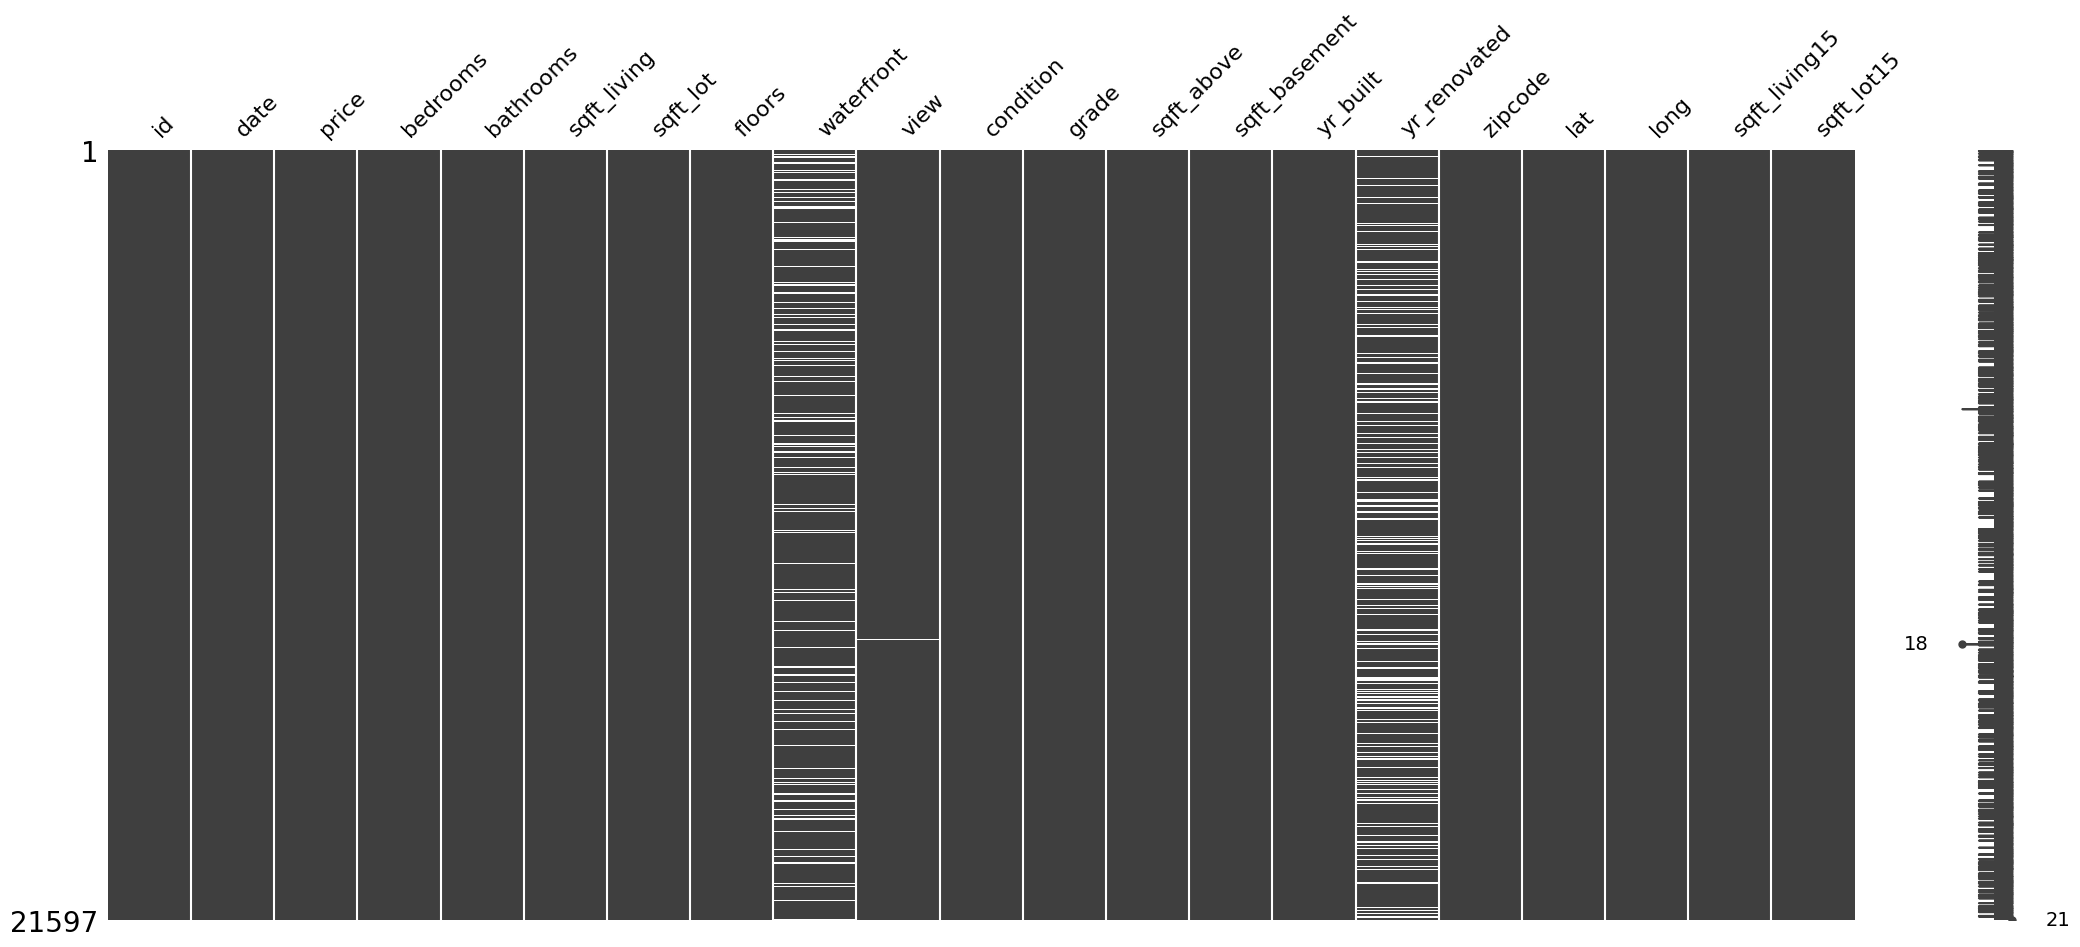

In [16]:
# treat NuN
# checking for missing data
import missingno as msno
data.isna().sum()
msno.matrix(data) 
# there are missing Data in waterfront, view, and yr_renovated - I assume the missing data indicate there is no information: no waterfront, no view or noch renovation. Filling those Nun with 0 will noch change any calculations 


<Axes: >

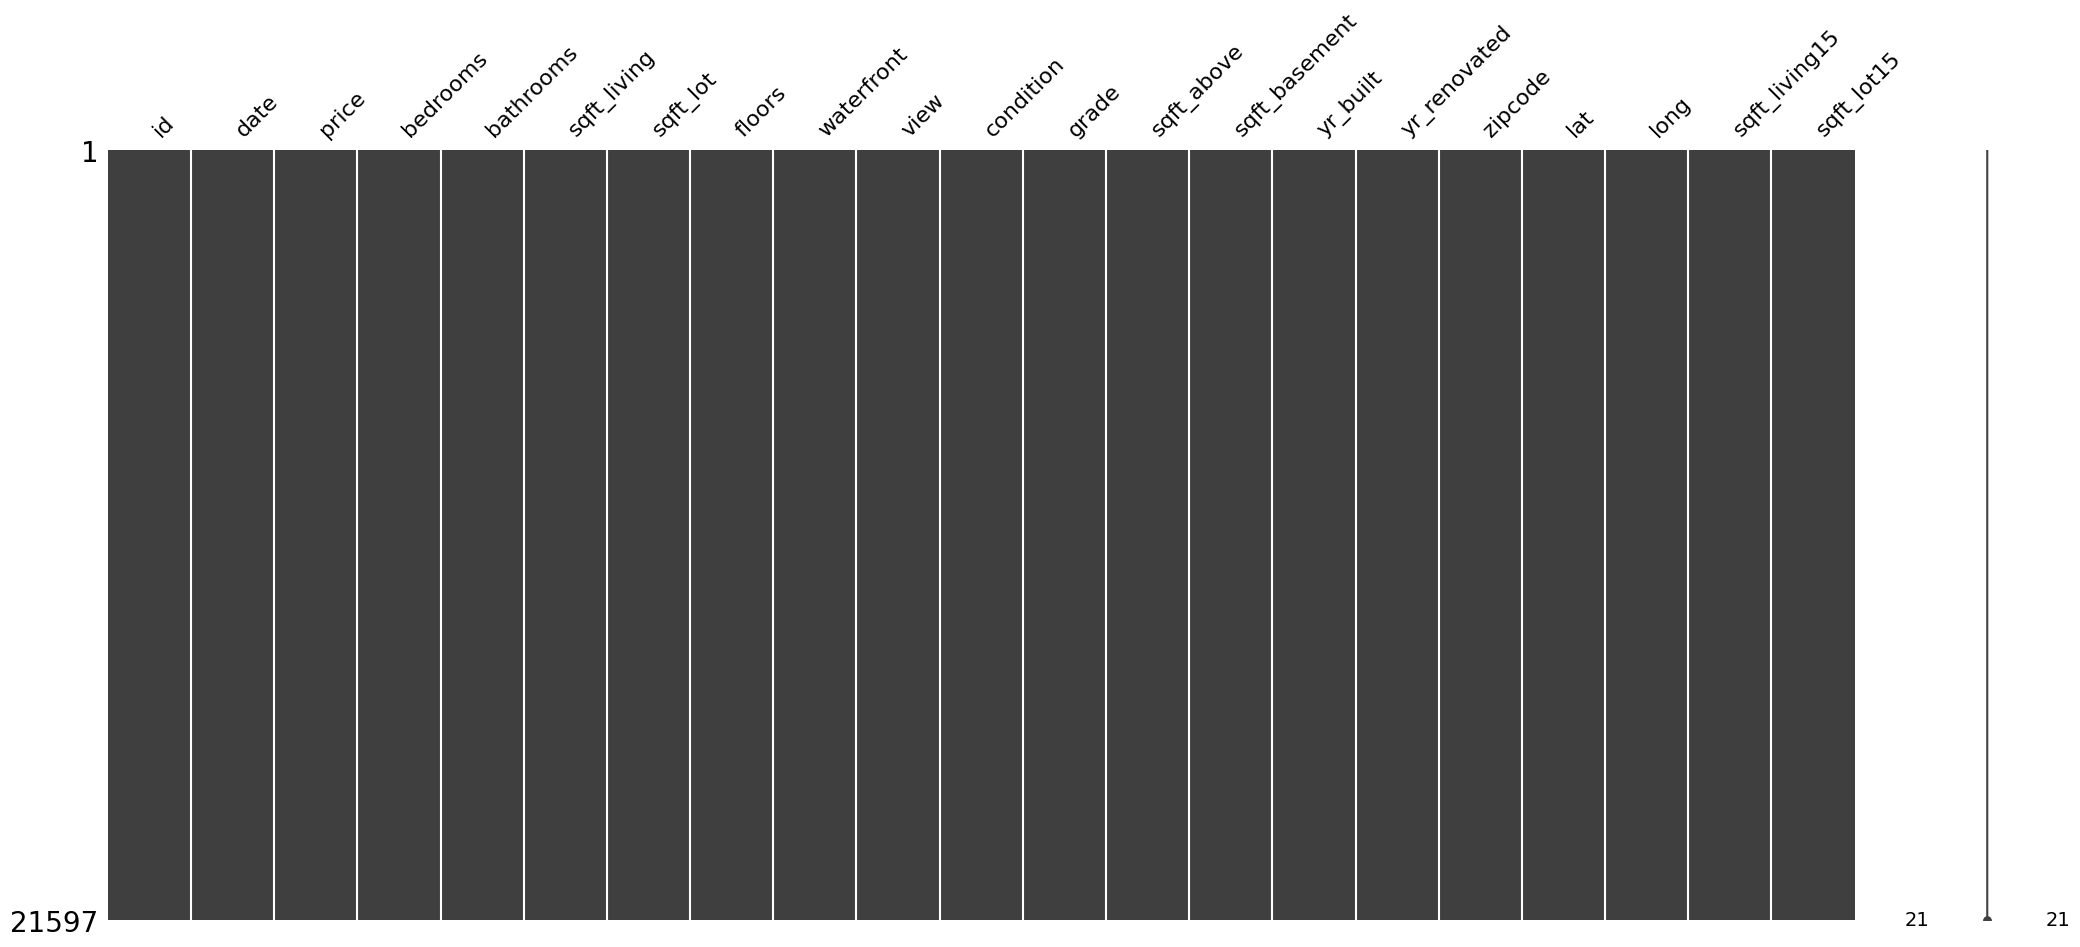

In [17]:
#Fill the Nun will the value 0
dfc = data.copy() # safetycopy

data.fillna(0, inplace=True)
data.reset_index(inplace=True, drop=True)
msno.matrix(data)